# Sampling using the score: Annealed Langevin Dynamics

This notebook presents the Annealed Langevin Dynamics to sample from a distribution whose score function is known.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
local_path = '../'
sys.path.append(local_path)

from utils.density_utils import gaussian_mixture_model_score, gaussian_mixture_model_density, gaussian_mixture_model_log_density
from utils.plot_utils import plot_langevin_trajectory, plot_empirical_true_density

from utils.density_utils import langevin_sampling, langevin_metropolis_hastings_sampling

### True density

We will use a Gaussian Mixture Model, whose parameters are defined below.

In [2]:
# Parameters for the Gaussian Mixture Model
weights = np.array([0.3, 0.7])
means = np.array([[0., 0.], [10., 10.]])
covariances = np.array([np.eye(2), np.eye(2)])

### Langevin dynamics

We use Langevin dynamics to generate samples using the true score.

In [3]:
coefficient = 1e-3
n_samples = 20000
x0 = 5 * np.random.randn(n_samples, 2) + np.array([5., 5.])

score_function = lambda x: gaussian_mixture_model_score(x, weights, means, covariances)
all_x = langevin_sampling(x0, score_function, n_samples, coefficient, T = 3000)
samples_langevin = all_x[-1]

Iteration: 100%|██████████| 3000/3000 [00:30<00:00, 98.76it/s]


We can look at these samples and the true density function:

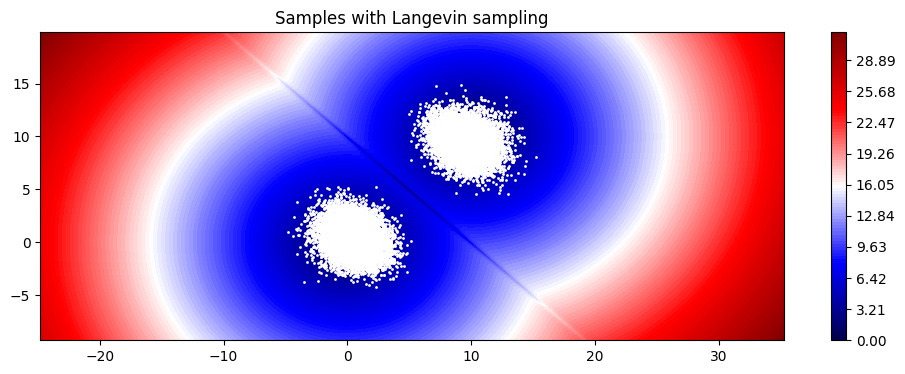

In [4]:
x_min, x_max = samples_langevin[:, 0].min() - 20, samples_langevin[:, 0].max() + 20
y_min, y_max = samples_langevin[:, 1].min() - 5, samples_langevin[:, 1].max() + 5
x = np.linspace(x_min, x_max, int(5 * (x_max - x_min)))
y = np.linspace(y_min, y_max, int(5 * (y_max - y_min)))

X, Y = np.meshgrid(x, y)
samples_ = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
scores = gaussian_mixture_model_score(samples_, weights, means, covariances)

magnitude = np.linalg.norm(scores, axis=1)

plt.figure(figsize = (12, 4))
plt.contourf(X, Y, magnitude.reshape(X.shape), cmap = "seismic", levels = np.linspace(0, magnitude.max(), 100))
plt.colorbar()
plt.scatter(samples_langevin[:, 0], samples_langevin[:, 1], s = 1, c = "white")
plt.title('Samples with Langevin sampling')
plt.show()

And we can look at some trajectories:

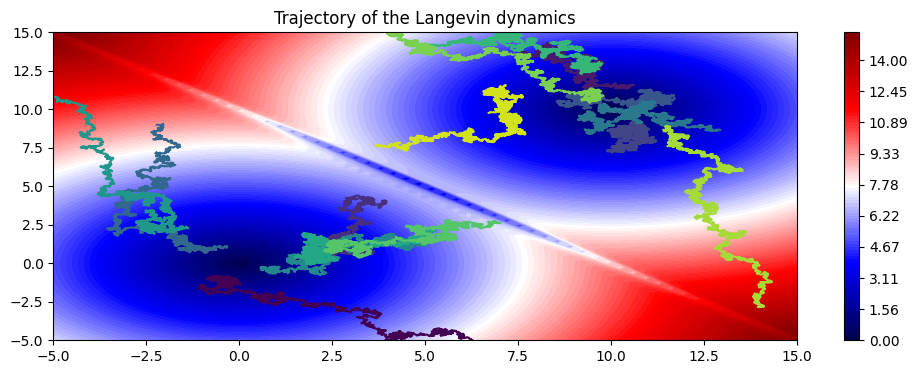

In [5]:
x_history = all_x[:, 0:15, :]
plot_langevin_trajectory(x_history, gaussian_mixture_model_score,
                         -5, 15, -5, 15, weights, means, covariances)

Finally, we can use the previous samples to plot the empirical density, as well as the true one.

<Figure size 1200x400 with 0 Axes>

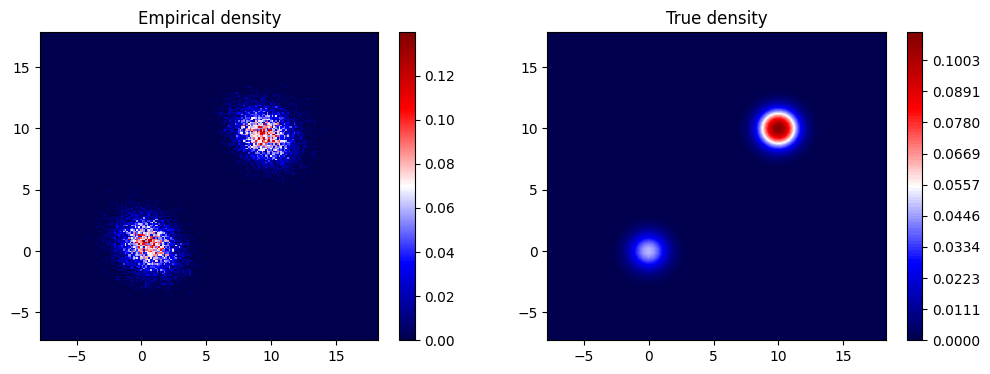

In [6]:
density_function = lambda x: gaussian_mixture_model_density(x, weights, means, covariances)
plot_empirical_true_density(samples_langevin, density_function)

We see that even though the means and covariance matrices have been well captured, the weights were not: Langevin dynamics leads to two clusters of same importance.

### Correction with Metropolis-Hastings algorithm

To solve this issue, we can add a step, using Metropolis-Hastings algorithm.

In [7]:
step = 1e-2
n_samples = 20000
x0 = 5 * np.random.randn(n_samples, 2) + np.array([5., 5.])

score_function = lambda x: gaussian_mixture_model_score(x, weights, means, covariances)
log_density_function = lambda x: gaussian_mixture_model_log_density(x, weights, means, covariances)

all_x_metropolis = langevin_metropolis_hastings_sampling(x0, score_function, log_density_function,
                                                         n_samples, step, T = 500)
samples_langevin_metropolis = all_x_metropolis[-1]

Iteration: 100%|██████████| 500/500 [00:19<00:00, 26.18it/s]

Acceptance rate: 0.9997781000000004


And here are the empirical density and the true density.

<Figure size 1200x400 with 0 Axes>

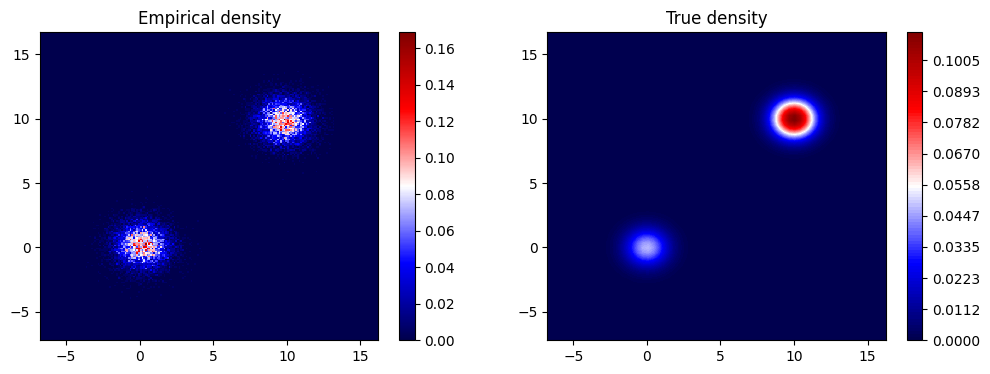

In [8]:
density_function = lambda x: gaussian_mixture_model_density(x, weights, means, covariances)
plot_empirical_true_density(samples_langevin_metropolis, density_function, smooth=False)